# Query objects around clusters in DC2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table, join, vstack

import pandas as pd

from GCR import GCRQuery
from GCRCatalogs.dc2_truth_match import _flux_to_mag as flux_to_mag
import GCRCatalogs
import fitsio

## cosmoDC2_small (truth) footprint

In [2]:
## https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/catalog_configs/cosmoDC2_v1.1.4_small.yaml

hp_ind = [9559,  9686,  9687,  9814,  9815,  9816,  
          9942,  9943, 10070, 10071, 10072, 10198, 10199, 10200, 10326, 10327, 10450]

truth_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [3]:
if 0:
    
    radec = pd.DataFrame()
    
    for pix in hp_ind:
        pix_data = truth_cat.get_quantities(['ra', 'dec'], filters=['mag_i < 19' ], 
                                        native_filters=[f'healpix_pixel == {pix}'])
        pix_data = pd.DataFrame(pix_data)
        pix_data['healpix_pixel'] = pix
        radec = pd.concat([radec, pix_data])
    
    radec.to_pickle('DC2_small_radec.pkl')
    
else:
    
    radec = pd.read_pickle('DC2_small_radec.pkl')

## find a tract of objects within the footprint

In [4]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons')

In [5]:
tract = 3449

## filters for the object catalog

cuts = [
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'),            # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                                  # and was not skipped by the deblender
    GCRQuery('mag_i_cModel < 19')  # cModel imag brighter than 24.5
]


# Load ra and dec from object, using both of the filters we just defined.
object_data = object_cat.get_quantities(['ra', 'dec'], filters=cuts,
                                       native_filters=[f'tract == {tract}'])

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


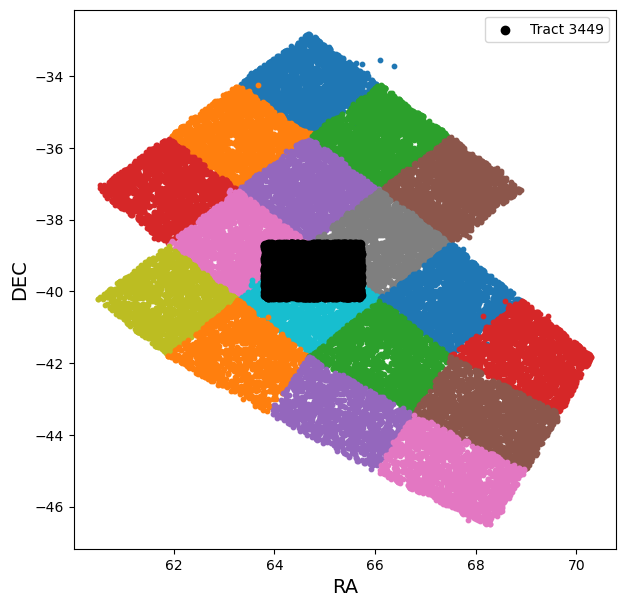

In [6]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

for pix in hp_ind:
    
    pix_data = radec[ radec['healpix_pixel'] == pix ]
    ax.scatter(pix_data['ra'], pix_data['dec'], s=10)
    
ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)

ax.scatter(object_data['ra'], object_data['dec'], c='k', label=f'Tract {tract}')

ax.legend()

## find healpix pixels that overlap with the tract

[9942, 9943, 10071]


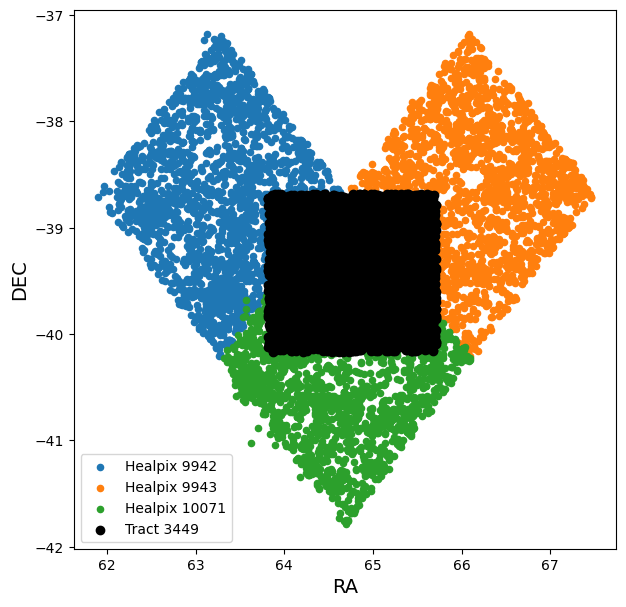

In [7]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

pix_overlap = []
for pix in hp_ind:
    
    pix_data = radec[ radec['healpix_pixel'] == pix ]
    if      np.any(pix_data['ra'] > object_data['ra'].min()) \
        and np.any(pix_data['ra'] < object_data['ra'].max()) \
        and np.any(pix_data['dec'] > object_data['dec'].min()) \
        and np.any(pix_data['dec'] < object_data['dec'].max()):
        
        ax.scatter(pix_data['ra'], pix_data['dec'], s=20, label=f'Healpix {pix}')
        pix_overlap.append(pix)
    
ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)

ax.scatter(object_data['ra'], object_data['dec'], c='k', label=f'Tract {tract}')
ax.legend()

print(pix_overlap)

## Read Redmapper (object) catalog

In [8]:
rm_cat = GCRCatalogs.load_catalog('dc2_redmapper_run2.2i_dr6_wfd_v0.8.1')

In [9]:
#rm_cat.list_all_quantities()

In [10]:
rm_data = rm_cat.get_quantities(rm_cat.list_all_quantities())

In [11]:
# for key in rm_data.keys():
#     print(len(rm_data[key]), key)

In [12]:
cl_columns = []
mem_columns = []

for key in rm_data.keys():
    if len(rm_data[key]) == 2819:
        cl_columns.append(key)
    elif len(rm_data[key]) == 176821:
        mem_columns.append(key)
        
print(len(cl_columns), '+', len(mem_columns), '=', len(rm_data.keys()))

30 + 21 = 51


In [13]:
cl_data = {key:rm_data[key] for key in cl_columns}
mem_data = {key:rm_data[key] for key in mem_columns}

cl_data = Table(cl_data)
mem_data = Table(mem_data)

#print(cl_data)
#print(mem_data)

## the entire redmapper footprint (cosmoDC2)

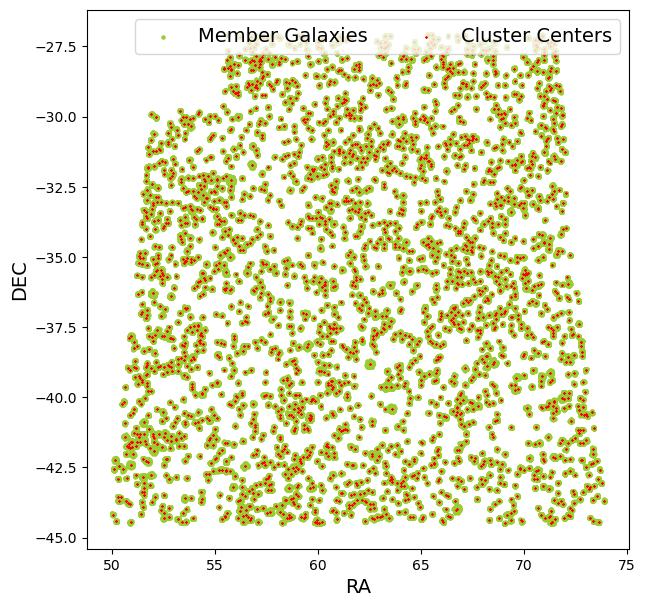

In [14]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

ax.scatter(mem_data['ra_member'], mem_data['dec_member'], c='yellowgreen', s=5, label='Member Galaxies')
ax.scatter(cl_data['ra_cen_0'], cl_data['dec_cen_0'], c='r', s=1, marker='x', label='Cluster Centers')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.legend(prop={'size':14}, ncol=2)


## look at one cluster with cluster id = 4

In [15]:
cid = 4

ind, = np.where( cl_data['cluster_id'] == cid)
ra0, dec0 = cl_data['ra_cen_0'][ind], cl_data['dec_cen_0'][ind]

ind, = np.where( mem_data['cluster_id_member'] == cid )
ra, dec = mem_data['ra_member'][ind], mem_data['dec_member'][ind]

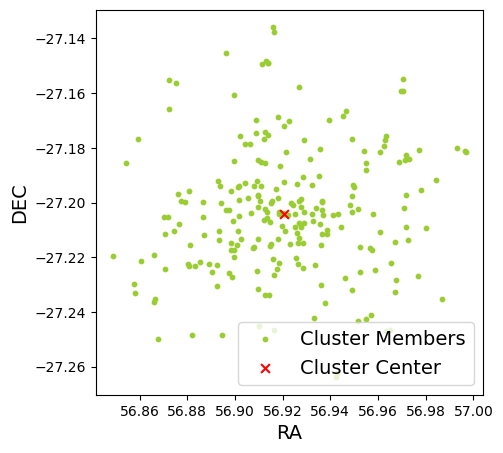

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.scatter(ra, dec, c='yellowgreen', s=10, label='Cluster Members')
ax.scatter(ra0, dec0, c='r', s=40, marker='x', label='Cluster Center')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.legend(prop={'size':14}, ncol=1);

## estimate cluster size

In [17]:
N_cl = len(cl_data)
ra_min = np.zeros(N_cl)
ra_max = np.zeros(N_cl)
dec_min = np.zeros(N_cl)
dec_max = np.zeros(N_cl)

for i, cid in enumerate(cl_data['cluster_id']):
    ind, = np.where( mem_data['cluster_id_member'] == cid )
    
    ra_min[i] = mem_data['ra_member'][ind].min()
    ra_max[i] = mem_data['ra_member'][ind].max()
    dec_min[i] = mem_data['dec_member'][ind].min()
    dec_max[i] = mem_data['dec_member'][ind].max()

cl_data['ra_min'], cl_data['ra_max'] = ra_min, ra_max
cl_data['dec_min'], cl_data['dec_max'] = dec_min, dec_max

## select on high quality clusters

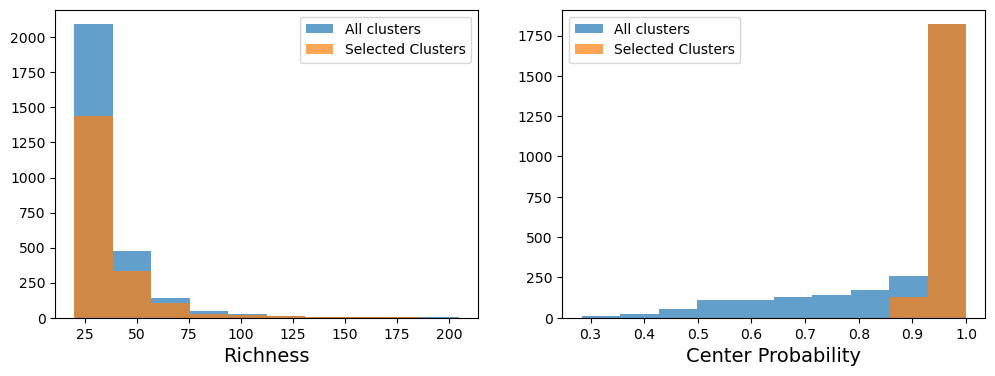

In [18]:
ind, = np.where( (cl_data['richness'] > 20 ) & ( cl_data['p_cen_0'] > 0.9) )
cl_sel = cl_data[ind]

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

n, bins, pat = ax1.hist(cl_data['richness'], alpha=0.7, label='All clusters')
ax1.hist(cl_sel['richness'], bins=bins, alpha=0.7, label='Selected Clusters')

n, bins, pat = ax2.hist(cl_data['p_cen_0'], alpha=0.7, label='All clusters')
ax2.hist(cl_sel['p_cen_0'], bins=bins, alpha=0.7, label='Selected Clusters')

ax1.set_xlabel('Richness', fontsize=14)
ax2.set_xlabel('Center Probability', fontsize=14)

ax1.legend()
ax2.legend()

## Get Objects in Tract 3449

In [19]:
if 0:
    
    object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons')
   
    ## filters for the object catalog
    '''
    cuts = [
        GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
        GCRQuery('clean'),            # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                                      # and was not skipped by the deblender
        GCRQuery('mag_i_cModel < 24.5')  # cModel imag brighter than 24.5
    ]
    '''
    
    # Load ra and dec from object, using both of the filters we just defined.
    object_data = object_cat.get_quantities(['ra', 'dec', 'x', 'y', 'extendedness', \
                                             'Ixx_pixel', 'Iyy_pixel', 'Ixy_pixel', \
                                          'mag_i_cModel', 'mag_r_cModel', \
                                         'photoz_mode', 'blendedness', 'tract', 'patch', 'clean'],
                                            native_filters=[f'tract == {tract}'])
                                        #filters=cuts, native_filters=[f'tract == {tract}'])
    
    obj_all = pd.DataFrame(object_data)
    obj_all['obj_id'] = [i for i in range(len(obj_all))]
    obj_all.to_pickle(f'obj_tract_{tract}.pkl')
    
else:
    
    obj_all = pd.read_pickle(f'obj_tract_{tract}.pkl')
    obj_all = Table.from_pandas(obj_all)

## Find clusters in tract

In [20]:
down_sample = np.random.randint(0, len(obj_all), size=10000)
obj_down = obj_all[down_sample]

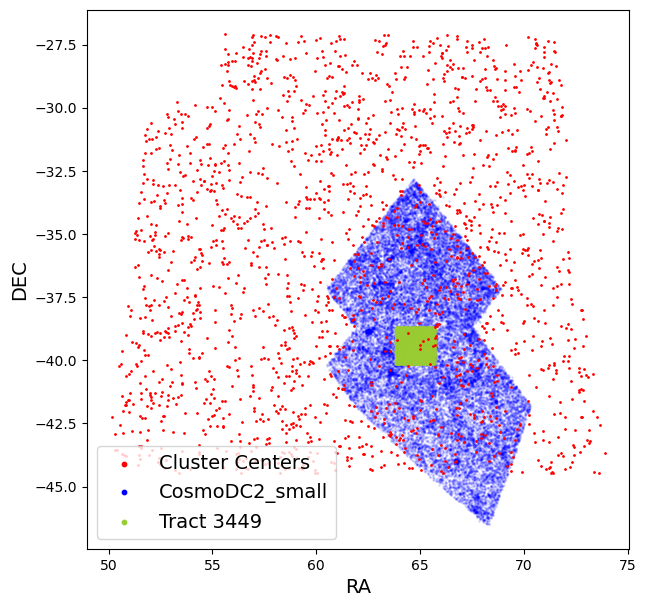

In [21]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

ax.scatter(radec['ra'], radec['dec'], c='b', s=1, alpha=0.1)
ax.scatter(obj_down['ra'], obj_down['dec'], c='yellowgreen', s=0.1)
ax.scatter(cl_sel['ra_cen_0'], cl_sel['dec_cen_0'], c='r', s=1)

ax.scatter([], [], s=10, c='r', label='Cluster Centers')
ax.scatter([], [], s=10, c='b', label='CosmoDC2_small')
ax.scatter([], [], s=10, c='yellowgreen', label=f'Tract {tract}')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.legend(prop={'size':14}, ncol=1)

In [22]:
ind, = np.where( (cl_sel['ra_min'] > obj_all['ra'].min()) & (cl_sel['ra_max'] < obj_all['ra'].max()) 
                & (cl_sel['dec_min'] > obj_all['dec'].min()) & (cl_sel['dec_max'] < obj_all['dec'].max()) )

cl_in_tract = cl_sel[ind]

In [23]:
# rand_ind = np.random.randint(0, len(obj_all), size=7)
# print(rand_ind)

rand_ind = [652398,  89595, 698106, 562381, 820454, 531471, 130378]

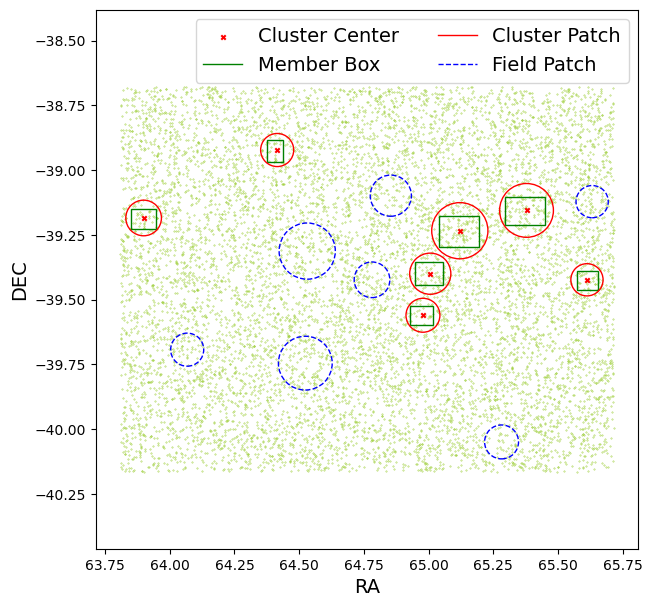

In [25]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

ax.scatter(obj_down['ra'], obj_down['dec'], c='yellowgreen', s=0.1)
ax.scatter(cl_in_tract['ra_cen_0'], cl_in_tract['dec_cen_0'], c='r', s=10, marker='x', label='Cluster Center')

for i in range(len(cl_in_tract)):
    ra_span = cl_in_tract['ra_max'][i] - cl_in_tract['ra_min'][i]
    dec_span = cl_in_tract['dec_max'][i] - cl_in_tract['dec_min'][i]
    
    rad = 1.3 * np.sqrt( (ra_span * np.cos(np.radians(cl_in_tract['dec_cen_0'][i])))**2 + dec_span**2) / 2
    
    rect = patches.Rectangle((cl_in_tract['ra_min'][i], cl_in_tract['dec_min'][i]),
                             ra_span, dec_span, linewidth=1, edgecolor='g', facecolor='none')
    
    circ1 = patches.Circle((cl_in_tract['ra_cen_0'][i], cl_in_tract['dec_cen_0'][i]),
                              radius=rad, linewidth=1, edgecolor='r', facecolor='none')
    
    ind = rand_ind[i]
    circ2 = patches.Circle((obj_all['ra'][ind], obj_all['dec'][ind]),
                              radius=rad, linewidth=1, edgecolor='b', ls='--', facecolor='none')
    
    #print(ind, (obj_all['ra'][ind], obj_all['dec'][ind]))
    ax.add_patch(rect)
    ax.add_patch(circ1)
    ax.add_patch(circ2)

ax.plot([], [], 'g', lw=1, label='Member Box')
ax.plot([], [], 'r', lw=1, label='Cluster Patch')
ax.plot([], [], 'b--', lw=1, label='Field Patch')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.axis('equal')
ax.legend(prop={'size':14}, ncol=2);

## Take out the Patches (cosmoDC2_small)

In [26]:
obj = Table()
rand = Table()

for i in range(len(cl_in_tract)):
  
    ### select cluster patches ###
    ra_span = cl_in_tract['ra_max'][i] - cl_in_tract['ra_min'][i]
    dec_span = cl_in_tract['dec_max'][i] - cl_in_tract['dec_min'][i]
    rad = 1.3 * np.sqrt( (ra_span * np.cos(np.radians(cl_in_tract['dec_cen_0'][i])))**2 + dec_span**2) / 2
    
    dist2 = (obj_all['ra'] - cl_in_tract['ra_cen_0'][i])**2 * np.cos(np.radians(cl_in_tract['dec_cen_0'][i]))**2 \
            + (obj_all['dec'] - cl_in_tract['dec_cen_0'][i])**2
    
    ind, = np.where( np.sqrt(dist2) < rad )
    
    obj_cl = obj_all[ind]
    obj_cl['cluster_id'] = cl_in_tract['cluster_id'][i]
    obj_cl['dist_to_center'] = np.sqrt( dist2[ind])
    obj_cl['norm_dist'] = obj_cl['dist_to_center'] / obj_cl['dist_to_center'].max()
    obj_cl['patch_type'] = 'cluster'
    obj = vstack( [obj, obj_cl] )
 
    ### select random patches as comparison ###
    r_ind = rand_ind[i]
    dist2 = (obj_all['ra'] - obj_all['ra'][r_ind])**2 * np.cos(np.radians(obj_all['dec'][r_ind]))**2 \
            + (obj_all['dec'] - obj_all['dec'][r_ind])**2
    
    ind, = np.where(np.sqrt(dist2) < rad )
    obj_rand = obj_all[ind]
    obj_rand['cluster_id'] = r_ind
    obj_rand['dist_to_center'] = np.sqrt( dist2[ind])
    obj_rand['norm_dist'] = obj_rand['dist_to_center']/obj_rand['dist_to_center'].max()
    obj_rand['patch_type'] = 'random'
    rand = vstack([rand, obj_rand])



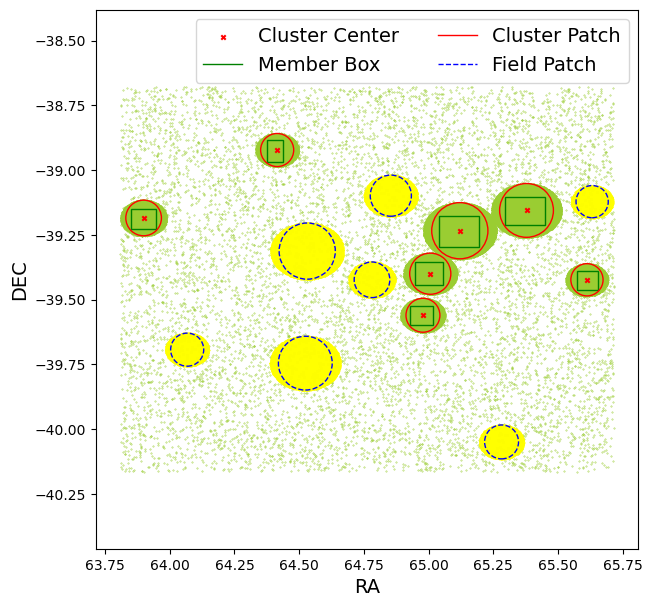

In [27]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

ax.scatter(obj_down['ra'], obj_down['dec'], c='yellowgreen', s=0.1)
ax.scatter(obj['ra'], obj['dec'], c='yellowgreen', s=0.1)
ax.scatter(rand['ra'], rand['dec'], c='yellow', s=0.1)
ax.scatter(cl_in_tract['ra_cen_0'], cl_in_tract['dec_cen_0'], c='r', s=10, marker='x', label='Cluster Center')

for i in range(len(cl_in_tract)):
    ra_span = cl_in_tract['ra_max'][i] - cl_in_tract['ra_min'][i]
    dec_span = cl_in_tract['dec_max'][i] - cl_in_tract['dec_min'][i]
    
    rad = 1.3 * np.sqrt( (ra_span * np.cos(np.radians(cl_in_tract['dec_cen_0'][i])))**2 + dec_span**2) / 2
    
    rect = patches.Rectangle((cl_in_tract['ra_min'][i], cl_in_tract['dec_min'][i]),
                             ra_span, dec_span, linewidth=1, edgecolor='g', facecolor='none')
    
    circ1 = patches.Circle((cl_in_tract['ra_cen_0'][i], cl_in_tract['dec_cen_0'][i]),
                              radius=rad, linewidth=1, edgecolor='r', facecolor='none')
    
    ind = rand_ind[i]
    circ2 = patches.Circle((obj_all['ra'][ind], obj_all['dec'][ind]),
                              radius=rad, linewidth=1, edgecolor='b', ls='--', facecolor='none')
    
    #print(ind, (obj_all['ra'][ind], obj_all['dec'][ind]))
    ax.add_patch(rect)
    ax.add_patch(circ1)
    ax.add_patch(circ2)

ax.plot([], [], 'g', lw=1, label='Member Box')
ax.plot([], [], 'r', lw=1, label='Cluster Patch')
ax.plot([], [], 'b--', lw=1, label='Field Patch')

ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.axis('equal')
ax.legend(prop={'size':14}, ncol=2);

### Query the truth catalog

In [28]:
if 0:
    
    truth_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
    stars_cat = GCRCatalogs.load_catalog("dc2_truth_run2.2i_star_truth_summary")
    
    #stars_cat.list_all_quantities()
    
    if not stars_cat.has_quantity("mag_i"):
        stars_cat.add_derived_quantity("mag_i", flux_to_mag, "flux_i")
    
    if not stars_cat.has_quantity("mag_r"):
        stars_cat.add_derived_quantity("mag_r", flux_to_mag, "flux_r")

    ra_min, ra_max = obj_all['ra'].min(), obj_all['ra'].max()
    dec_min, dec_max = obj_all['dec'].min(), obj_all['dec'].max()
                                                             

    pos_filters = [f'ra >= {ra_min}',f'ra <={ra_max}', f'dec >= {dec_min}', f'dec <= {dec_max}']

    filters = pos_filters  + ['mag_i < 28' ]

    truth_gals = truth_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'mag_i', 'mag_r', 'redshift',\
                                           'size_true', 'size_minor_true', 'position_angle_true',
                                           'halo_id', 'halo_mass', 'is_central'], filters=filters)
    truth_gals = pd.DataFrame(truth_gals)

    truth_gals["star"] = False
    truth_gals = truth_gals.rename(columns={"galaxy_id": "id"})



    truth_stars = stars_cat.get_quantities(['id', 'ra', 'dec', 'mag_i', 'mag_r', 'redshift'], filters=filters)
    truth_stars = pd.DataFrame(truth_stars)

    for col in ['size_true', 'size_minor_true', 'position_angle_true','halo_id', 'halo_mass', 'is_central']:
        truth_stars[col] = 0

    truth_stars["star"] = True
    truth_stars["id"] = truth_stars["id"].astype(np.int64)

    truth = pd.concat([truth_gals, truth_stars], ignore_index=True)
    truth.to_pickle(f'truth_tract_{tract}.pkl')
    
else:
    
    truth = pd.read_pickle(f'truth_tract_{tract}.pkl')
    truth = Table.from_pandas(truth)